## 앙상블 학습 개요

* 앙상블 학습 (Ensemble Learning)을 통한 분류 : 여러 개의 분류기 (Classifier)를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법 (단일 분류기보다 신뢰성이 높은 예측값을 얻을 수 있음)
* 대부분의 정형 데이터 분류는 앙상블이 뛰어난 성능
* 앙상블 algorithm : random forest, gradient boosting method, (XGBoost, LightGBM, Stacking)

### 앙상블 학습의 유형

보팅 & 배깅 : 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식


- **보팅(voting)** : 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합


- **배깅(bagging)** : 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅 수행 (대표적인 배깅 방식이 random forest algorithm)


- **부스팅(boosting)** : 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서는 올바르게 예측할 수 있도록 다음 분류기에는 가중치(weight)를 부여하면서 학습과 예측을 진행하는 것. 예측 성능이 뛰어나 앙상블 학습을 주도. 대표적인 부스팅 모듈로 gradient boost, XGBoost, LightGBM이 있음. 


- **스태킹(Stacking)** : 여러 가지 다른 모델의 예측 결괏값을 다시 학습 데이터로 만들어서 다른 모델(메타 모델)로 재학습시켜 결과를 예측하는 방법



### (1) 보팅

* Hard Voting : 다수의 classifier 간 다수결로 최종 class 결정
* Soft Voting : 다수의 classifier 들의 class 확률을 평균해서 롹률이 가장 높은 레이블 값을 선정

일반적으로 hard < soft

scikit-learn은 "VotingClassifier"클래스를 통해 voting classifier를 생성할 수 있음 (parameter = esimators, voting)
* estimators는 리스트 값으로 보팅에 사용될 여러 개의 Classifier 객체들을 튜플 형식으로 입력받음
* voting은 'hard'시 하드보팅, 'soft'시 소프트 보팅 방식 적용 (default는 'hard')

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [2]:
# 개별 모델은 logistic regression & KNN.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 soft voting 기반의 ensemble model로 구현한 classifier
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting = 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,test_size=0.2, random_state=100)

In [3]:
# Voting Classifier 학습 / 예습 / 평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9649122807017544

In [4]:
# 개별 classifier 학습 / 예습 / 평가
lr_clf.fit(X_train, y_train)
pred_lr = lr_clf.predict(X_test)
accuracy_score(y_test, pred_lr)

0.9473684210526315

In [5]:
# .. 이어서
knn_clf.fit(X_train, y_train)
pred_knn = knn_clf.predict(X_test)
accuracy_score(y_test, pred_knn)

0.9473684210526315

보팅 분류기가 정확도가 개별 분류기(로지스틱 회귀, knn)보다 조금 높게 나타났는데, 보팅으로 여러 개의 기반 분류기를 결합한다고 해서 무조건 기반 분류기보다 예측 성능이 향상되는건 아님. 

### (2) 배깅 
#### 랜덤 포레스트

* Bagging의 대표적 알고리즘
* 앙상블 알고리즘 중 빠른 수행 속도, 다양한 영역에서 높은 예측 성능 
* 기반 알고리즘 = **결정트리**

*부트스트래핑 분할* : 전체 데이터에서 일부가 중첩되게 sampling된 data set 

ex : 원본 data의 건수가 10인 train data set에 random forest를 3개의 decision tree 기반으로 학습하려고 n_estimators=3으로 하이퍼파라미터를 부여함. 

scikit learn에서는 RandomForestClassifer 클래스 제공 (아래는 하이퍼파라미터들)

* n_estimators : decision tree 개수 
* max_features : 참조하는 최대 feature 개수 (어떤 피쳐를 참조하는지는 결정트리마다 다를 수 있음)
* max_depth, min_samples_leaf, min_samples_split : 결정트리에서 과적합 개선하기 위해 쓰는 파라미터들 동일하게 적용

In [6]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [8]:

def get_new_feature_name_df(old_df):
    feature_dup_df = pd.DataFrame(data=old_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test



X_train, X_test, y_train, y_test = get_human_dataset()

In [9]:
# randomforestclassifier 학습, 예측, 평가

rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred_rf = rf_clf.predict(X_test)
accuracy_score(y_test, pred_rf)

0.9195792331184255

**트리 기반 앙상블 알고리즘**의 **단점** : 하이퍼 파라미터가 너무 많고, 그로 인해 튜닝을 위한 시간이 많이 소모됨. 

#### GridSearchCV를 이용한 랜덤 포레스트 하이퍼 파라미터 튜닝

In [10]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8,16,24],
    'min_samples_leaf' : [1,6,12],
    'min_samples_split': [2,8,16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv=2)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
grid_cv.best_score_

{'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}


0.9164853101196953

In [11]:
# 위에서 찾은 최적 파라미터를 대입해서 RandomForestClassifier 생성
rf_clf1 = RandomForestClassifier(n_estimators=100,random_state=0,
                                max_depth=16, min_samples_leaf=6, 
                                min_samples_split=2)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도:', accuracy_score(y_test, pred)) # 정확도 살짝 상승함

예측 정확도: 0.9260264675941635


random forest 같은 **tree** 계열들은 대부분 피쳐 중요도를 얻을 수 있음!

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_importances.sort_values(ascending=False)

angle(X,gravityMean)              0.035312
tGravityAcc-mean()-Y              0.033729
tGravityAcc-min()-X               0.030276
angle(Y,gravityMean)              0.029013
tGravityAcc-max()-X               0.027538
                                    ...   
fBodyAccJerk-min()-X              0.000024
fBodyAcc-min()-Y                  0.000023
fBodyAcc-bandsEnergy()-33,40_1    0.000014
fBodyAcc-bandsEnergy()-49,56      0.000010
fBodyAccJerk-entropy()-Y          0.000009
Length: 561, dtype: float64

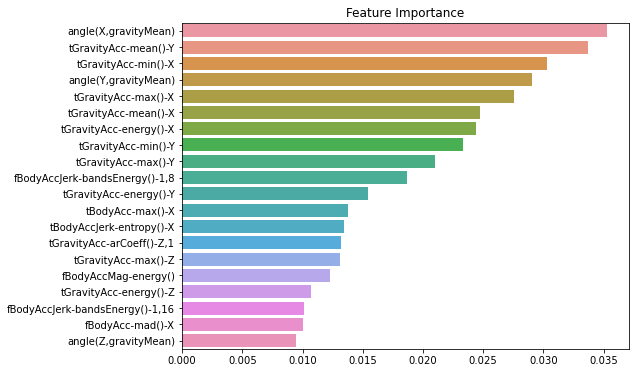

In [15]:
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()